## 1. Importing libraries and dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import regex as re
from datetime import datetime as dt
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 20)

/kaggle/input/crossroads-classic-datathon-2021/TCU_HolidayList.csv
/kaggle/input/crossroads-classic-datathon-2021/DataDictionary.xlsx
/kaggle/input/crossroads-classic-datathon-2021/Training.csv
/kaggle/input/crossroads-classic-datathon-2021/Training_SupplementalFields.csv


In [2]:
training_filepath = '/kaggle/input/crossroads-classic-datathon-2021/Training.csv'
training_supp_filepath = '/kaggle/input/crossroads-classic-datathon-2021/Training_SupplementalFields.csv'
dictionary_filepath = '/kaggle/input/crossroads-classic-datathon-2021/DataDictionary.xlsx'
holiday_filepath = '/kaggle/input/crossroads-classic-datathon-2021/TCU_HolidayList.csv'

train = pd.read_csv(training_filepath)
train_supp = pd.read_csv(training_supp_filepath)
dictionary = pd.read_excel(dictionary_filepath)
holidays = pd.read_csv(holiday_filepath)

In [3]:
train.head()

,BusinessDate,BranchID,CashOrdersReceived,CashBalance_StartOfDay,TotalCashUsed
0,07/31/2020,99,-,"775,054.00","(43,718.13)"
1,07/30/2020,99,-,"1,036,464.13","261,410.14"
2,07/29/2020,99,"400,540.11","1,141,386.84","104,922.70"
3,07/28/2020,99,-,"864,871.20","124,024.48"
4,07/27/2020,99,-,"923,948.57","59,077.37"


In [4]:
train.shape

(171230, 5)

## 2. Data cleaning

In [5]:
train.rename(columns=lambda x: x.strip(),inplace=True)
train['BusinessDate'] = pd.to_datetime(train['BusinessDate'])
train['BranchID'] = train['BranchID'].astype('str')

In [1]:
train['TotalCashUsed'] = train['TotalCashUsed'].str.replace(")","") 
train['TotalCashUsed'] = train['TotalCashUsed'].str.replace(",","") 
train['TotalCashUsed'] = train['TotalCashUsed'].str.replace(" ","") 
train['TotalCashUsed'] = train['TotalCashUsed'].str.replace("-","0")
train['TotalCashUsed'] = train['TotalCashUsed'].str.replace("(","-") 
train['TotalCashUsed'] = train['TotalCashUsed'].astype('float')
# train.replace(0,np.nan,inplace=True)

NameError: name 'train' is not defined

In [7]:
train.head()

,BusinessDate,BranchID,CashOrdersReceived,CashBalance_StartOfDay,TotalCashUsed
0,2020-07-31,99,-,"775,054.00",-43718.13
1,2020-07-30,99,-,"1,036,464.13",261410.14
2,2020-07-29,99,"400,540.11","1,141,386.84",104922.70
3,2020-07-28,99,-,"864,871.20",124024.48
4,2020-07-27,99,-,"923,948.57",59077.37


## 3. Feature engineering

In [8]:
#Date related features
train['BusinessDate'] = pd.to_datetime(train['BusinessDate'])
train['DayofWeek'] = train['BusinessDate'].dt.dayofweek
train['Month'] = train['BusinessDate'].dt.month
train['DayofMonth'] = train['BusinessDate'].dt.day
train['MonthEnd'] = np.where(train['BusinessDate'].dt.is_month_end,1,0)


#Specific period related features
train['Holiday'] = train['BusinessDate'].isin(holidays['HolidayDate']).astype(int)
# train['COVIDPeriod'] = np.where(train['BusinessDate']>'2020-03-20',1,0)
train

,BusinessDate,BranchID,CashOrdersReceived,CashBalance_StartOfDay,TotalCashUsed,DayofWeek,Month,DayofMonth,MonthEnd,Holiday
0,2020-07-31,99,-,"775,054.00",-43718.13,4,7,31,1,0
1,2020-07-30,99,-,"1,036,464.13",261410.14,3,7,30,0,0
2,2020-07-29,99,"400,540.11","1,141,386.84",104922.70,2,7,29,0,0
3,2020-07-28,99,-,"864,871.20",124024.48,1,7,28,0,0
4,2020-07-27,99,-,"923,948.57",59077.37,0,7,27,0,0
...,...,...,...,...,...,...,...,...,...,...
171225,2010-01-05,501,-,"1,823,349.64",128908.86,1,1,5,0,0
171226,2010-01-04,501,-,"1,869,916.04",46566.40,0,1,4,0,0
171227,2010-01-03,501,-,"1,950,717.56",80801.52,6,1,3,0,0
171228,2010-01-02,501,-,"1,950,717.56",0.00,5,1,2,0,0


In [9]:
train_pivot = pd.pivot_table(train,values='TotalCashUsed',index='BusinessDate',aggfunc='sum')
train_pivot

,TotalCashUsed
BusinessDate,
2010-01-01,1599004.05
2010-01-02,0.00
2010-01-03,3417118.94
2010-01-04,1956116.61
2010-01-05,2288372.97
...,...
2020-07-27,1277209.22
2020-07-28,5136111.36
2020-07-29,1404346.94


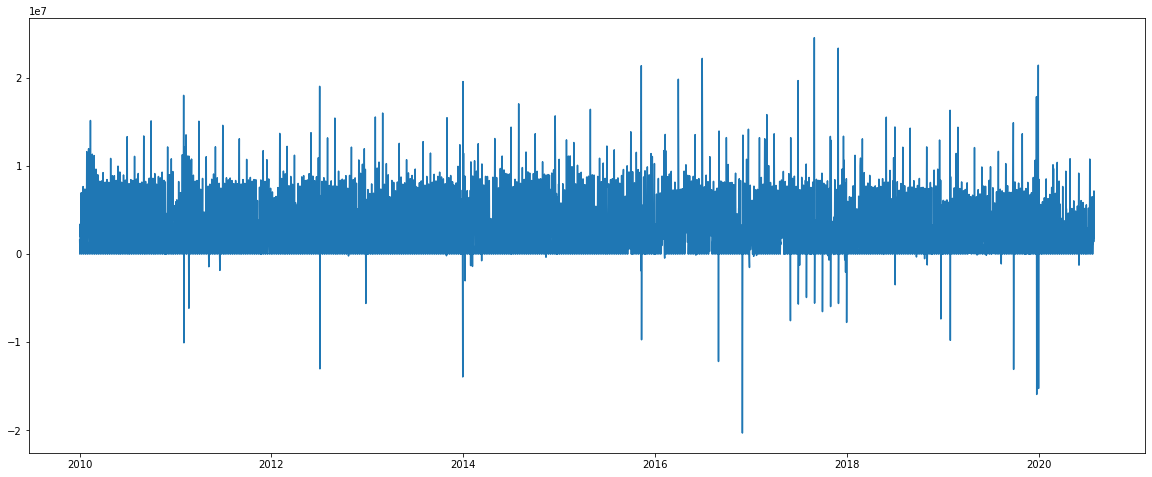

In [10]:
plt.figure(figsize=(20,8))
plt.plot(train_pivot);

Let us delete the events that have values more than 20000000 or less than -20000000 which look like outlier events across all years

In [11]:
anomaly_df

NameError: name 'anomaly_df' is not defined

In [12]:
anomaly_df = train_pivot.loc[(train_pivot['TotalCashUsed']>20000000) | (train_pivot['TotalCashUsed']<-20000000)]
train['Drop'] = train['BusinessDate'].isin(anomaly_df.index).astype(int)
train.drop(train[train['Drop'] == 1].index,inplace=True)
train.drop(labels='Drop',axis=1,inplace=True)
train.head()

,BusinessDate,BranchID,CashOrdersReceived,CashBalance_StartOfDay,TotalCashUsed,DayofWeek,Month,DayofMonth,MonthEnd,Holiday
0,2020-07-31,99,-,"775,054.00",-43718.13,4,7,31,1,0
1,2020-07-30,99,-,"1,036,464.13",261410.14,3,7,30,0,0
2,2020-07-29,99,"400,540.11","1,141,386.84",104922.70,2,7,29,0,0
3,2020-07-28,99,-,"864,871.20",124024.48,1,7,28,0,0
4,2020-07-27,99,-,"923,948.57",59077.37,0,7,27,0,0


In [13]:
#Rule1: Saturdays on holidays
train.loc[(train.Holiday == 1) & (train.DayofWeek == 5) ,'TotalCashUsed'] = 0

#Rule2: Saturdays except for on month ends
train.loc[(train.DayofWeek == 5) & (~train.BusinessDate.dt.day.isin([29,30,31])) , 'TotalCashUsed'] = 0



In [14]:
#Creating branch averages and assigning classes based on cumulative percentages

branch_avg = train.pivot_table(values='TotalCashUsed',index='BranchID',aggfunc='mean')
branch_avg.sort_values(by='TotalCashUsed',ascending=False,inplace=True)
branch_avg['cum_sum'] = 100*branch_avg['TotalCashUsed']/branch_avg['TotalCashUsed'].sum()
branch_cat = pd.cut(branch_avg['cum_sum'],3, labels=["small", "medium", "large"])

bcd = branch_cat.to_dict()
def assign_class(branch_id):
    return bcd.get(branch_id)

train['Branch_Cat'] = pd.Series(train['BranchID'].apply(lambda row: assign_class(row)))

In [15]:
branch_cat

BranchID
270     large
382     large
433     large
469     large
203     large
289    medium
154    medium
336    medium
501    medium
325    medium
434    medium
155    medium
108    medium
125    medium
415    medium
362    medium
118     small
111     small
99      small
196     small
323     small
133     small
115     small
370     small
317     small
144     small
334     small
110     small
217     small
169     small
131     small
230     small
425     small
356     small
273     small
140     small
177     small
441     small
344     small
367     small
319     small
126     small
364     small
151     small
290     small
333     small
267     small
398     small
458     small
Name: cum_sum, dtype: category
Categories (3, object): ['small' < 'medium' < 'large']

## 4. Pre-processing

In [16]:
train['BusinessDate'] = pd.to_datetime(train['BusinessDate'])
train['BusinessDate'] = train['BusinessDate'].map(dt.toordinal)

In [17]:
train.columns

Index(['BusinessDate', 'BranchID', 'CashOrdersReceived',
       'CashBalance_StartOfDay', 'TotalCashUsed', 'DayofWeek', 'Month',
       'DayofMonth', 'MonthEnd', 'Holiday', 'Branch_Cat'],
      dtype='object')

In [18]:
X = train.drop(['CashOrdersReceived','CashBalance_StartOfDay','TotalCashUsed'],axis=1)
X = pd.get_dummies(X,drop_first=True)
y = train['TotalCashUsed']

In [19]:
# train.to_csv('/kaggle/working/preprocessed_train.csv',index=None)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=2021)

## 5. Model execution and evaluation

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [22]:
import timeit
start_time = timeit.default_timer()
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_val)
lr_smape = round(smape(y_val,lr_pred),2)
elapsed = timeit.default_timer() - start_time
model_comparison = pd.DataFrame(lr_smape,columns=['SMAPE'],index=['Linear Regression'])
model_comparison['Runtime (in secs)'] = round(elapsed,2)

In [23]:
# start_time = timeit.default_timer()
# rf = RandomForestRegressor()
# rf.fit(X_train,y_train)
# rf_pred = rf.predict(X_val)
# rf_smape = smape(y_val,rf_pred)
# elapsed = timeit.default_timer() - start_time
# model_comparison.loc['Random Forest Regression'] = rf_smape
# model_comparison['Runtime (in secs)'].loc['Random Forest Regression'] = elapsed

In [24]:
start_time = timeit.default_timer()
xgbr = XGBRegressor(random_state=2021)
xgbr.fit(X_train,y_train)
xgbr_pred = xgbr.predict(X_val)
xgbr_smape = round(smape(y_val,xgbr_pred),2)
elapsed = timeit.default_timer() - start_time
model_comparison.loc['XG Boost Regressor'] = xgbr_smape
model_comparison['Runtime (in secs)'].loc['XG Boost Regressor'] = round(elapsed,2)

In [25]:
start_time = timeit.default_timer()
catbr = CatBoostRegressor(random_state=2021,silent=True)
catbr.fit(X_train,y_train)
catbr_pred = catbr.predict(X_val)
catbr_smape = round(smape(y_val,catbr_pred),2)
elapsed = timeit.default_timer() - start_time
model_comparison.loc['Cat Boost Regressor'] = catbr_smape
model_comparison['Runtime (in secs)'].loc['Cat Boost Regressor'] = round(elapsed,2)

In [26]:
start_time = timeit.default_timer()
lgbm = LGBMRegressor(random_state=2021)
lgbm.fit(X_train,y_train)
lgbm_pred = lgbm.predict(X_val)
elapsed = timeit.default_timer() - start_time
lgbm_smape = round(smape(y_val,lgbm_pred),2)
model_comparison.loc['LGBM Regressor'] = lgbm_smape
model_comparison['Runtime (in secs)'].loc['LGBM Regressor'] = round(elapsed,2)

In [27]:
model_comparison

,SMAPE,Runtime (in secs)
Linear Regression,115.07,0.31
XG Boost Regressor,101.54,16.44
Cat Boost Regressor,101.98,16.60
LGBM Regressor,101.64,1.84


## 6. Hyperparameter tuning for LGBM

In [28]:
# from sklearn.metrics import make_scorer

# parameters = {'learning_rate':[0.1,0.01,1.0],
#          'num_leaves': [20,35,50,75,100],
#          'max_depth':[-1,-0.1,1]}
# my_scorer = make_scorer(smape, greater_is_better=False)
# lgbm_grid = GridSearchCV(estimator=LGBMRegressor(random_state=2021),param_grid=parameters,scoring=my_scorer,cv=3,verbose=1)
# lgbm_grid.fit(X,y)

In [29]:
# lgbm_grid.best_params_

In [30]:
# lgbmgridpred = lgbm_grid.predict(X_val)
# print(mean_absolute_error(y_val,lgbmgridpred))
# print(np.sqrt(mean_squared_error(y_val,lgbmgridpred)))
# print(smape(y_val,lgbmgridpred))

In [31]:
final_model = LGBMRegressor(random_state=2021,learning_rate=0.01,max_depth=-1,num_leaves=50)
final_model.fit(X,y)

LGBMRegressor(learning_rate=0.01, num_leaves=50, random_state=2021)

In [32]:
lgbm_feature_importances = pd.DataFrame(final_model.feature_importances_,index = X.columns,columns=['Variable importance']).sort_values('Variable importance',ascending=False)
lgbm_feature_importances['Percent Importance'] = round((lgbm_feature_importances['Variable importance'] / lgbm_feature_importances['Variable importance'].sum()) * 100,2)
lgbm_feature_importances

,Variable importance,Percent Importance
DayofWeek,1080,22.04
DayofMonth,734,14.98
BusinessDate,429,8.76
Branch_Cat_medium,256,5.22
Holiday,181,3.69
MonthEnd,174,3.55
BranchID_323,159,3.24
BranchID_118,154,3.14
BranchID_270,152,3.10
BranchID_433,146,2.98


## 7. Model for each branch group

In [33]:
large_x_train

NameError: name 'large_x_train' is not defined

In [34]:
large_train = train[train['Branch_Cat']=='large']
large_x_train = large_train.drop(['CashOrdersReceived','CashBalance_StartOfDay','TotalCashUsed','Branch_Cat'],axis=1)
large_x_train = pd.get_dummies(large_x_train)
large_y_train = large_train['TotalCashUsed']
large_model = LGBMRegressor(random_state=2021,learning_rate=0.01,max_depth=-1,num_leaves=50)
large_model.fit(large_x_train,large_y_train)

LGBMRegressor(learning_rate=0.01, num_leaves=50, random_state=2021)

In [35]:
medium_train = train[train['Branch_Cat']=='medium']
medium_x_train = medium_train.drop(['CashOrdersReceived','CashBalance_StartOfDay','TotalCashUsed','Branch_Cat'],axis=1)
medium_x_train = pd.get_dummies(medium_x_train)
medium_y_train = medium_train['TotalCashUsed']
medium_model = LGBMRegressor(random_state=2021,learning_rate=0.01,max_depth=-1,num_leaves=50)
medium_model.fit(medium_x_train,medium_y_train)

LGBMRegressor(learning_rate=0.01, num_leaves=50, random_state=2021)

In [36]:
small_train = train[train['Branch_Cat']=='small']
small_x_train = small_train.drop(['CashOrdersReceived','CashBalance_StartOfDay','TotalCashUsed','Branch_Cat'],axis=1)
small_x_train = pd.get_dummies(small_x_train)
small_y_train = small_train['TotalCashUsed']
small_model = LGBMRegressor(random_state=2021,learning_rate=0.01,max_depth=-1,num_leaves=50)
small_model.fit(small_x_train,small_y_train)

LGBMRegressor(learning_rate=0.01, num_leaves=50, random_state=2021)

## 8. Test predictions

In [37]:
unique_branch = list(train['BranchID'].unique())
from datetime import timedelta, date
final = list()
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 8, 1)
end_dt = date(2020, 11, 30)
for dt in daterange(start_dt, end_dt):
    for i in unique_branch:
        final_1 = str(dt) + '_' + i
        final.append(final_1)
final

date_series = []
branch_series = []
for i in final:
    date = i.split(sep='_')[0]
    branch_code = i.split(sep='_')[1]
    date_series.append(date)
    branch_series.append(branch_code)

In [38]:
X_test = pd.DataFrame()

In [39]:
X_test = pd.DataFrame(data=[date_series,branch_series],index=['BusinessDate', 'BranchID']).T
X_test['BusinessDate'] = pd.to_datetime(X_test['BusinessDate'])
X_test['DayofWeek'] = X_test['BusinessDate'].dt.dayofweek
X_test['Month'] = X_test['BusinessDate'].dt.month
X_test['DayofMonth'] = X_test['BusinessDate'].dt.day
X_test['MonthEnd'] = np.where(X_test['BusinessDate'].dt.is_month_end,1,0)

#Specific period related features
X_test['Holiday'] = X_test['BusinessDate'].isin(holidays['HolidayDate']).astype(int)


X_test['BusinessDate'] = pd.to_datetime(X_test['BusinessDate'])
X_test['BusinessDate'] = X_test['BusinessDate'].apply(lambda x: x.toordinal())


#added variable for branch category
#Creating branch averages and assigning classes based on cumulative percentages

X_test['Branch_Cat'] = pd.Series(X_test['BranchID'].apply(lambda row: assign_class(row)))


In [40]:
X_test

,BusinessDate,BranchID,DayofWeek,Month,DayofMonth,MonthEnd,Holiday,Branch_Cat
0,737638,99,5,8,1,0,0,small
1,737638,108,5,8,1,0,0,medium
2,737638,110,5,8,1,0,0,small
3,737638,111,5,8,1,0,0,small
4,737638,115,5,8,1,0,0,small
...,...,...,...,...,...,...,...,...
5973,737759,434,0,11,30,1,0,medium
5974,737759,441,0,11,30,1,0,small
5975,737759,458,0,11,30,1,0,small
5976,737759,469,0,11,30,1,0,large


In [41]:
large_test = pd.DataFrame()

In [42]:
#Predictions by individual grouped models

large_test = X_test[X_test['Branch_Cat']=='large']
large_test = large_test.drop('Branch_Cat',axis=1)
large_test = pd.get_dummies(large_test)
large_preds = large_model.predict(large_test)


large_test['TotalCashUsed  '] = large_preds
large_test['BusinessDate'] = large_test['BusinessDate'].map(dt.fromordinal)
large_test['BusinessDate'] = pd.to_datetime(large_test['BusinessDate'])

#Rule1: Saturdays on holidays
large_test.loc[(large_test.Holiday == 1) & (large_test.DayofWeek == 5) ,'TotalCashUsed  '] = 0

#Rule2: Saturdays except for on month ends
large_test.loc[(large_test.DayofWeek == 5) & (~large_test.BusinessDate.dt.day.isin([29,30,31])) , 'TotalCashUsed  '] = 0


large_col = []
large_branch = list(large_train['BranchID'].unique())

for i in range(3866,3866+122):
    for j in large_branch:
        col_value = str(i) + '_' + j
        large_col.append(col_value)
        
large_submission = pd.DataFrame(data=[large_col,large_test['TotalCashUsed  ']],index=['Date_Branch', 'TotalCashUsed  ']).T
large_submission

,Date_Branch,TotalCashUsed
0,3866_203,0
1,3866_270,0
2,3866_382,0
3,3866_433,0
4,3866_469,0
...,...,...
605,3987_203,139484
606,3987_270,146209
607,3987_382,141218
608,3987_433,141218


In [43]:
#Predictions by individual grouped models

medium_test = X_test[X_test['Branch_Cat']=='medium']
medium_test = medium_test.drop('Branch_Cat',axis=1)
medium_test = pd.get_dummies(medium_test)
medium_preds = medium_model.predict(medium_test)


medium_test['TotalCashUsed  '] = medium_preds
medium_test['BusinessDate'] = medium_test['BusinessDate'].map(dt.fromordinal)
medium_test['BusinessDate'] = pd.to_datetime(medium_test['BusinessDate'])

#Rule1: Saturdays on holidays
medium_test.loc[(medium_test.Holiday == 1) & (medium_test.DayofWeek == 5) ,'TotalCashUsed  '] = 0

#Rule2: Saturdays except for on month ends
medium_test.loc[(medium_test.DayofWeek == 5) & (~medium_test.BusinessDate.dt.day.isin([29,30,31])) , 'TotalCashUsed  '] = 0


medium_col = []
medium_branch = list(medium_train['BranchID'].unique())

for i in range(3866,3866+122):
    for j in medium_branch:
        col_value = str(i) + '_' + j
        medium_col.append(col_value)
        
medium_submission = pd.DataFrame(data=[medium_col,medium_test['TotalCashUsed  ']],index=['Date_Branch', 'TotalCashUsed  ']).T
medium_submission

,Date_Branch,TotalCashUsed
0,3866_108,0
1,3866_125,0
2,3866_154,0
3,3866_155,0
4,3866_289,0
...,...,...
1337,3987_336,111009
1338,3987_362,92639
1339,3987_415,111009
1340,3987_434,111009


In [44]:
#Predictions by individual grouped models

small_test = X_test[X_test['Branch_Cat']=='small']
small_test = small_test.drop('Branch_Cat',axis=1)
small_test = pd.get_dummies(small_test)
small_preds = small_model.predict(small_test)


small_test['TotalCashUsed  '] = small_preds
small_test['BusinessDate'] = small_test['BusinessDate'].map(dt.fromordinal)
small_test['BusinessDate'] = pd.to_datetime(small_test['BusinessDate'])

#Rule1: Saturdays on holidays
small_test.loc[(small_test.Holiday == 1) & (small_test.DayofWeek == 5) ,'TotalCashUsed  '] = 0

#Rule2: Saturdays except for on month ends
small_test.loc[(small_test.DayofWeek == 5) & (~small_test.BusinessDate.dt.day.isin([29,30,31])) , 'TotalCashUsed  '] = 0


small_col = []
small_branch = list(small_train['BranchID'].unique())

for i in range(3866,3866+122):
    for j in small_branch:
        col_value = str(i) + '_' + j
        small_col.append(col_value)
        
small_submission = pd.DataFrame(data=[small_col,small_test['TotalCashUsed  ']],index=['Date_Branch', 'TotalCashUsed  ']).T
small_submission

,Date_Branch,TotalCashUsed
0,3866_99,0
1,3866_110,0
2,3866_111,0
3,3866_115,0
4,3866_118,0
...,...,...
4021,3987_370,26245.7
4022,3987_398,26245.7
4023,3987_425,26245.7
4024,3987_441,26245.7


In [45]:
submission

NameError: name 'submission' is not defined

In [46]:
submission = pd.concat([large_submission,medium_submission,small_submission])
submission
submission.to_csv('/kaggle/working/Submission_v5.csv',index=None)

In [47]:
# X_test = pd.get_dummies(X_test,drop_first=True)
# y_test = pd.Series(final_model.predict(X_test),name='y_test')
# y_test.shape

In [48]:
# test = pd.merge(X_test,y_test,left_index=True,right_index=True)
# test['BusinessDate'] = test['BusinessDate'].map(dt.fromordinal)
# test['BusinessDate'] = pd.to_datetime(test['BusinessDate'])

In [49]:
# test.rename(columns={'y_test':'TotalCashUsed  '},inplace=True)

In [50]:
# #Rule1: Saturdays on holidays
# test.loc[(test.Holiday == 1) & (test.DayofWeek == 5) ,'TotalCashUsed'] = 0

# #Rule2: Saturdays except for on month ends
# test.loc[(test.DayofWeek == 5) & (~test.BusinessDate.dt.day.isin([29,30,31])) , 'TotalCashUsed  '] = 0

In [51]:
# y_test = test['TotalCashUsed  ']

In [52]:
# unique_branch = list(train['BranchID'].unique())
# submission_col1 = list()

# for i in range(3866,3866+122):
#     for j in unique_branch:
#         col_value = str(i) + '_' + j
#         submission_col1.append(col_value)

In [53]:
# submission = pd.DataFrame(data=[submission_col1,y_test],index=['Date_Branch', 'TotalCashUsed  ']).T
# submission

In [54]:
# submission.to_csv('/kaggle/working/Submission_v5.csv',index=None)